In [112]:
import pyrealsense2 as rs
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import os

## Creating Depth and Color Images

In [113]:
width = 1280
height = 720
fps = 30

In [174]:
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, width, height, rs.format.z16, fps)
config.enable_stream(rs.stream.color, width, height, rs.format.rgb8, fps)

In [175]:
profile = pipeline.start(config)

In [176]:
align_to = rs.stream.color
align = rs.align(align_to)

In [177]:
frames = pipeline.wait_for_frames()

In [178]:
aligned_frames = align.process(frames)

depth_frame = aligned_frames.get_depth_frame()
color_frame = aligned_frames.get_color_frame()

depth_image = np.asanyarray(depth_frame.get_data())
color_image = np.asanyarray(color_frame.get_data())

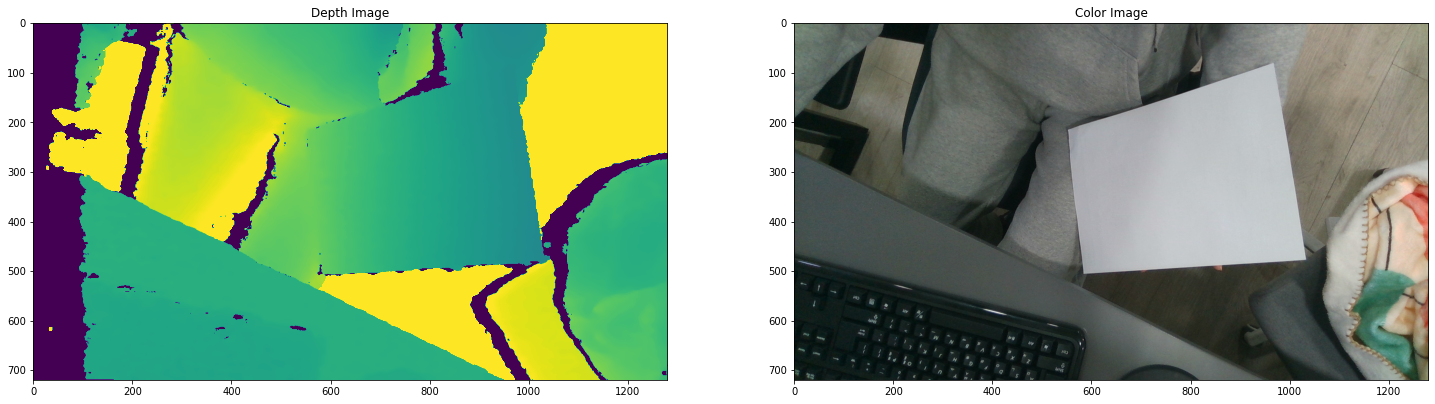

In [179]:
fig = plt.figure(figsize=(25,10))
row = 1
col = 2

ax1 = fig.add_subplot(row,col,1)
ax1.imshow(depth_image, vmin=200, vmax=800)
ax1.set_title("Depth Image")

ax2 = fig.add_subplot(row,col,2)
ax2.imshow(color_image)
ax2.set_title("Color Image")

plt.show()

In [180]:
pipeline.stop()

## Filtering a Depth Image

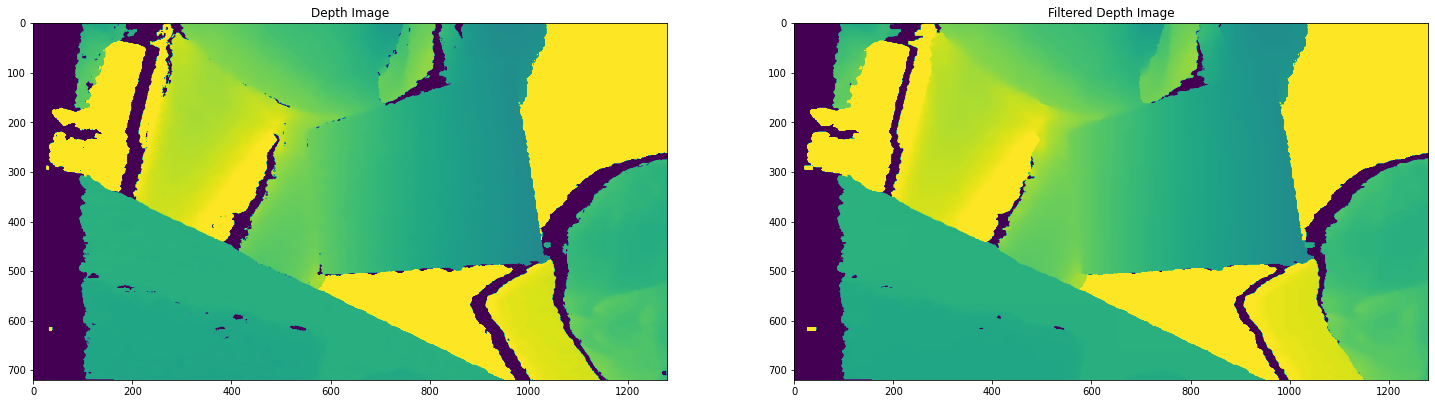

In [181]:
spatial = rs.spatial_filter()
spatial.set_option(rs.option.holes_fill, 2)

filtered_depth = spatial.process(depth_frame)
filtered_depth_image = np.asanyarray(filtered_depth.get_data())

fig = plt.figure(figsize=(25,10))
row = 1
col = 2

ax1 = fig.add_subplot(row,col,1)
ax1.imshow(depth_image, vmin=200, vmax=800)
ax1.set_title("Depth Image")

ax2 = fig.add_subplot(row,col,2)
ax2.imshow(filtered_depth_image, vmin=200, vmax=800)
ax2.set_title("Filtered Depth Image")

plt.show()

## Save Images

In [182]:
np.save('depth_image.npy', depth_image)
np.save('filtered_depth_image.npy', filtered_depth_image)
np.save('color_image.npy', color_image)

## Mask and Normal Vector Generation

In [183]:
def generate_mask(event,x,y,flag,data):
    if event == cv2.EVENT_FLAG_LBUTTON:
        cv2.circle(data['im'],(x,y),3,(0,255,0),5,16)
        cv2.imshow("Mask",data["im"])
        if len(data["points"]) < 4:
            data['points'].append([x,y])

def get_normal(event,x,y,flag,data):
    if event == cv2.EVENT_FLAG_LBUTTON:
        cv2.circle(data['im'],(x,y),3,(0,0,255),5,16)
        cv2.imshow("Normal",data["im"])
        if len(data["points"]) < 3:
            data['points'].append([x,y])
    
def get_points(im,type):
    data = {}
    data['im'] = cv2.cvtColor(im.copy(),cv2.COLOR_RGB2BGR)
    data['points'] = []
    
    if type == "mask":
        cv2.imshow("Mask",cv2.cvtColor(im,cv2.COLOR_RGB2BGR))
        cv2.setMouseCallback("Mask",generate_mask,data)
    else:
        cv2.imshow("Normal",cv2.cvtColor(im,cv2.COLOR_RGB2BGR))
        cv2.setMouseCallback("Normal",get_normal,data)
    cv2.waitKey(0)

    points = np.array(data['points'],dtype=float)
    return points


In [184]:
depth_image = np.load('filtered_depth_image.npy')
color_image = np.load('color_image.npy')

In [185]:
mask_points = get_points(color_image,"mask")

cv2.waitKey(0)
cv2.destroyAllWindows()

QObject::moveToThread: Current thread (0x55d39b511310) is not the object's thread (0x55d39b4d99d0).
Cannot move to target thread (0x55d39b511310)

QObject::moveToThread: Current thread (0x55d39b511310) is not the object's thread (0x55d39b4d99d0).
Cannot move to target thread (0x55d39b511310)

QObject::moveToThread: Current thread (0x55d39b511310) is not the object's thread (0x55d39b4d99d0).
Cannot move to target thread (0x55d39b511310)

QObject::moveToThread: Current thread (0x55d39b511310) is not the object's thread (0x55d39b4d99d0).
Cannot move to target thread (0x55d39b511310)

QObject::moveToThread: Current thread (0x55d39b511310) is not the object's thread (0x55d39b4d99d0).
Cannot move to target thread (0x55d39b511310)

QObject::moveToThread: Current thread (0x55d39b511310) is not the object's thread (0x55d39b4d99d0).
Cannot move to target thread (0x55d39b511310)

QObject::moveToThread: Current thread (0x55d39b511310) is not the object's thread (0x55d39b4d99d0).
Cannot move to tar

In [186]:
np.save('mask_points.npy', mask_points)

mask_points

array([[ 553.,  217.],
       [ 585.,  505.],
       [1032.,  476.],
       [ 967.,   82.]])

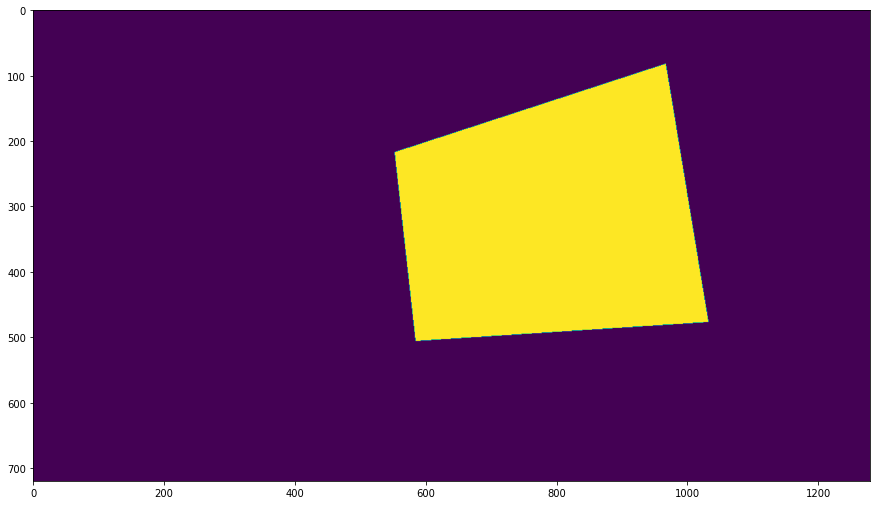

In [187]:
mask_points = np.load('mask_points.npy')

mask = np.zeros(color_image.shape[:2], dtype="uint8")

cv2.fillPoly(mask, np.int32([mask_points]), 1)
plt.figure(figsize=(15,25))
plt.imshow(mask)

In [211]:
def seed_everything(num: int = 20):
    random.seed(num)
    np.random.seed(num)
    os.environ["PYTHONHASHSEED"] = str(num)

seed_everything()

non_index = np.nonzero(mask)
num = len(non_index[0])

normal_x = []
normal_y = []
for _ in range(100):
    random_ = np.random.choice(num, size=3, replace=False)
    normal_y.append(non_index[0][random_])
    normal_x.append(non_index[1][random_])

normal_y = np.array(normal_y)
normal_x = np.array(normal_x)

rand_idx = np.random.choice(100)

rand_idx, normal_x[rand_idx], normal_y[rand_idx]

(82, array([811, 614, 797]), array([242, 423, 178]))

In [212]:
masked_depth = cv2.bitwise_and(depth_image,depth_image,mask=mask)

import math

deg_h = 69.4
deg_v = 42.5

px_h = masked_depth * math.tan(math.radians(deg_h/2)) / (depth_image.shape[1] / 2)
px_v = masked_depth * math.tan(math.radians(deg_v/2)) / (depth_image.shape[0] / 2)

centroid_x = np.ceil(np.sum(normal_x, axis=1) / 3)
centroid_y = np.ceil(np.sum(normal_y, axis=1) / 3)

centroid_x = centroid_x.astype(int)
centroid_y = centroid_y.astype(int)

centroid_x[rand_idx], centroid_y[rand_idx]

(741, 281)

In [213]:
x_local = []
y_local = []

for k in range(len(normal_x)):
    x_center = centroid_x[k]
    y_center = centroid_y[k]
    
    sum_x = 0
    x_coor = []
    for i in range(3):
        coor = normal_x[k][i]
        if x_center <= coor:
            sum_x = np.sum(px_h[y_center,x_center:coor+1])
        else:
            sum_x = np.sum(px_h[y_center,coor:x_center+1])
            sum_x = -sum_x
        x_coor.append(sum_x)
        sum_x = 0
    x_local.append(x_coor)

    sum_y = 0
    y_coor = []
    for i in range(3):
        coor = normal_y[k][i]
        if y_center <= coor:
            sum_y = np.sum(px_v[y_center:coor+1,x_center])
            sum_y = -sum_y
        else:
            sum_y = np.sum(px_v[coor:y_center+1,x_center])
        y_coor.append(sum_y)
        sum_y = 0
    y_local.append(y_coor)

x_local = np.array(x_local)
y_local = np.array(y_local)

x_local[rand_idx], y_local[rand_idx]

(array([ 43.78880289, -84.50277126,  35.30974653]),
 array([ 25.21770554, -89.96169352,  65.59195966]))

In [ ]:
"""
INVALID BECAUSE WIDTH AND HEIGHT ARE IN PIXELS NOT IN MM

x_world = []
y_world = []
for k in range(len(x_local)):
    x_temp = x_local[k]
    x_true = np.array(x_temp) + centroid_x[k] - width/2

    y_temp = y_local[k]
    y_true = np.array(y_temp) + centroid_y[k] - height/2
    
    x_world.append(x_true)
    y_world.append(y_true)

x_world = np.array(x_world)
y_world = np.array(y_world)

x_world[0], y_world[0]
"""

In [215]:
A_xy = np.transpose(np.array([x_local[:,0],y_local[:,0]]))
B_xy = np.transpose(np.array([x_local[:,1],y_local[:,1]]))
C_xy = np.transpose(np.array([x_local[:,2],y_local[:,2]]))

A = np.concatenate((A_xy,depth_image[normal_y[:,0],normal_x[:,0]].reshape((100,1))), axis=1)
B = np.concatenate((B_xy,depth_image[normal_y[:,1],normal_x[:,1]].reshape((100,1))), axis=1)
C = np.concatenate((C_xy,depth_image[normal_y[:,2],normal_x[:,2]].reshape((100,1))), axis=1)

AB = B - A
CB = B - C

normal = np.cross(AB,CB)
norm_unit = normal / np.linalg.norm(normal, axis=1).reshape(100,1)

norm_unit[rand_idx]

array([0.5338216 , 0.00739282, 0.84556481])

In [216]:
camera = np.array([0,-1])

norm_unit_x = norm_unit[:,[0,2]]
norm_unit_x = norm_unit_x / np.linalg.norm(norm_unit_x, axis=1).reshape(100,1)

norm_unit_y = norm_unit[:,[1,2]]
norm_unit_y = norm_unit_y / np.linalg.norm(norm_unit_y, axis=1).reshape(100,1)

dot_product_x = np.dot(norm_unit_x, camera)
dot_product_y = np.dot(norm_unit_y, camera)
angle_x = np.arccos(dot_product_x)
angle_y = np.arccos(dot_product_y)

np.degrees(angle_x[rand_idx]), np.degrees(angle_y[rand_idx])

(147.73498075518472, 179.499072836829)

In [217]:
px_h_true = []
px_v_true = []

for i in range(len(angle_x)):
    px_h_true.append(px_h / math.cos(angle_x[i]))
    px_v_true.append(px_v / math.cos(angle_y[i]))

area = np.array(px_h_true) * np.array(px_v_true)
paper_area = np.average(np.sum(np.sum(area, axis=2), axis=1))

In [218]:
error = np.abs(paper_area - 62370)/62370 * 100

print("Area of the paper is {:0.2f} mm^2.".format(paper_area))
print("True value is 62370 mm^2.")
print("Percent error is {:0.2f}%.".format(error))

Area of the paper is 69312.76 mm^2.
True value is 62370 mm^2.
Percent error is 11.13%.
